In [1]:
import sys
import matplotlib
%matplotlib inline
import argparse
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
from notebooks.data_loader import *
from notebooks.helper_fxns import *
from notebooks.print_n_plot import *
from notebooks.build_network import *
from notebooks.train_val import *
import warnings
import lasagne
import theano
from theano import tensor as T
import sys
import numpy as np
import logging
import time
import pickle
import argparse
from os.path import join

importing Jupyter notebook from notebooks/data_loader.ipynb
importing Jupyter notebook from notebooks/helper_fxns.ipynb
importing Jupyter notebook from notebooks/print_n_plot.ipynb
importing Jupyter notebook from notebooks/build_network.ipynb
importing Jupyter notebook from notebooks/train_val.ipynb
importing Jupyter notebook from notebooks/objectives.ipynb


In [2]:
def setup_kwargs():
    
    default_args = {'input_shape': tuple([None] + [1, 50, 50]), 
                      'learning_rate': 0.01, 
                      'dropout_p': 0, 
                      'weight_decay': 0, #0.0001, 
                      'num_filters': 10, 
                      'num_fc_units': 32,
                      'num_layers': 4,
                      'momentum': 0.9,
                      'num_epochs': 20000,
                      'batch_size': 128,
                     "save_path": "None",
                    "num_events": -1,
                    "sig_eff_at": 0.9996, "test":False}
    
    
    # if inside a notebook, then get rid of weird notebook arguments, so that arg parsing still works
    if any(["jupyter" in arg for arg in sys.argv]):
        sys.argv=sys.argv[:1]


    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    #make a command line argument for every flag in default args
    for k,v in default_args.iteritems():
        parser.add_argument('--' + k, type=type(v), default=v, help=k)

    args = parser.parse_args()
    
    if args.save_path == "None":
        save_path = None
    else:
        save_path = args.save_path


    kwargs = default_args
    kwargs.update(args.__dict__)
    run_dir = create_run_dir(save_path)
    kwargs['save_path'] = run_dir
    kwargs["logger"] = get_logger(kwargs['save_path'])

    return kwargs

time:  3.22884511948


{'learning_rate': 0.01, 'num_layers': 4, 'input_shape': (None, 1, 50, 50), 'batch_size': 128, 'dropout_p': 0, 'num_events': -1, 'num_epochs': 20000, 'weight_decay': 0, 'num_train': 23808, 'num_val': 5952, 'sig_eff_at': 0.9996, 'num_fc_units': 32, 'save_path': './results/run236', 'num_filters': 10, 'test': False, 'logger': <logging.Logger object at 0x2b2e353726d0>, 'momentum': 0.9}
<lasagne.layers.input.InputLayer object at 0x2b2e2365b4d0>(None, 1, 50, 50)
<lasagne.layers.conv.Conv2DLayer object at 0x2b2e355b7710>(None, 10, 50, 50)
<lasagne.layers.normalization.BatchNormLayer object at 0x2b2e355d1b50>(None, 10, 50, 50)
<lasagne.layers.special.NonlinearityLayer object at 0x2b2e04c49e50>(None, 10, 50, 50)
<lasagne.layers.pool.MaxPool2DLayer object at 0x2b2e355d1b10>(None, 10, 25, 25)
<lasagne.layers.conv.Conv2DLayer object at 0x2b2e353a6410>(None, 10, 25, 25)
<lasagne.layers.normalization.BatchNormLayer object at 0x2b2e355d1ad0>(None, 10, 25, 25)
<lasagne.layers.special.NonlinearityLayer 

5928




<lasagne.layers.input.InputLayer object at 0x2b2e2365b4d0> : (None, 1, 50, 50)
<lasagne.layers.conv.Conv2DLayer object at 0x2b2e355b7710> : (None, 10, 50, 50)
<lasagne.layers.normalization.BatchNormLayer object at 0x2b2e355d1b50> : (None, 10, 50, 50)
<lasagne.layers.special.NonlinearityLayer object at 0x2b2e04c49e50> : (None, 10, 50, 50)
<lasagne.layers.pool.MaxPool2DLayer object at 0x2b2e355d1b10> : (None, 10, 25, 25)
<lasagne.layers.conv.Conv2DLayer object at 0x2b2e353a6410> : (None, 10, 25, 25)
<lasagne.layers.normalization.BatchNormLayer object at 0x2b2e355d1ad0> : (None, 10, 25, 25)
<lasagne.layers.special.NonlinearityLayer object at 0x2b2e3540df50> : (None, 10, 25, 25)
<lasagne.layers.pool.MaxPool2DLayer object at 0x2b2e353a6890> : (None, 10, 12, 12)
<lasagne.layers.conv.Conv2DLayer object at 0x2b2e353a69d0> : (None, 10, 12, 12)
<lasagne.layers.normalization.BatchNormLayer object at 0x2b2e353a6ed0> : (None, 10, 12, 12)
<lasagne.layers.special.NonlinearityLayer object at 0x2b2e3

beginning epoch 0


/usr/common/software/python/2.7-anaconda/envs/deeplearning/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


beginning epoch 0


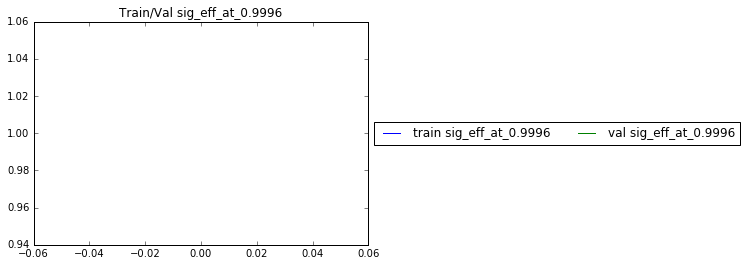

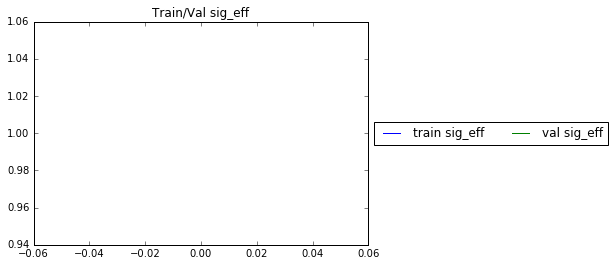

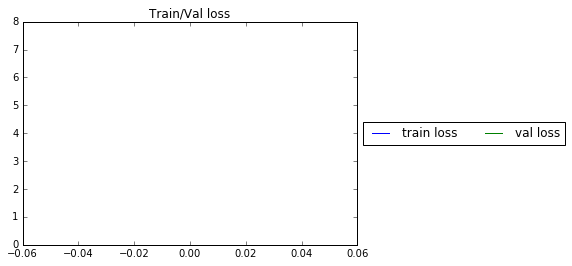

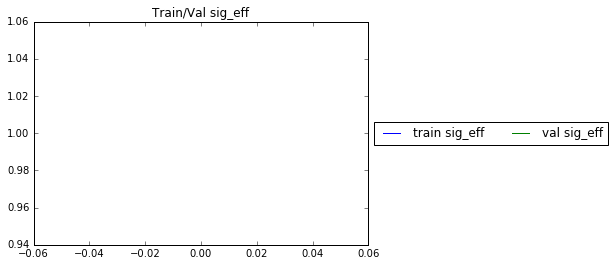

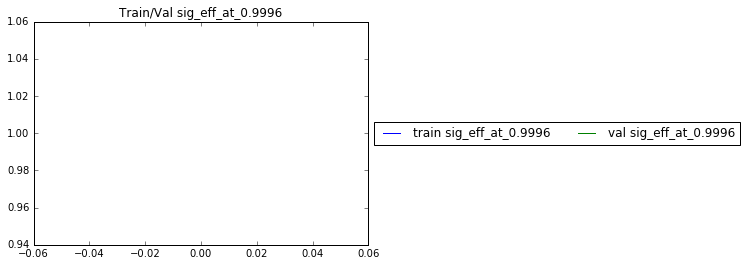

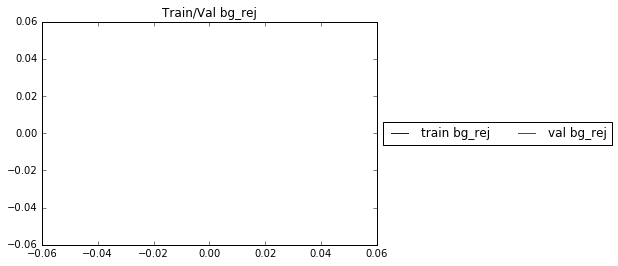

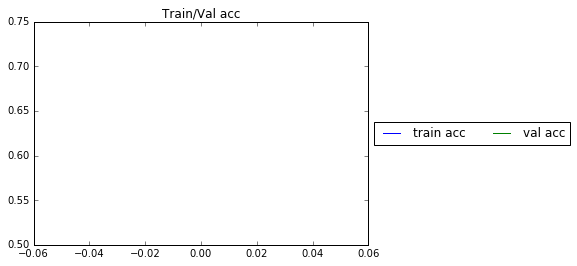

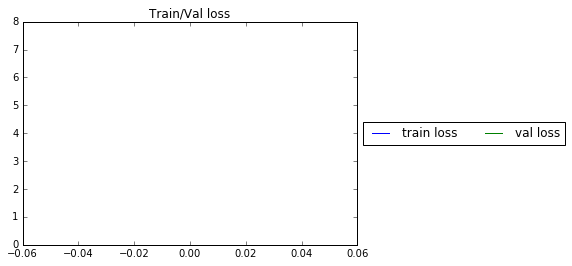

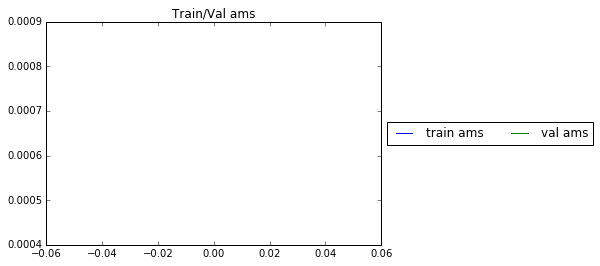

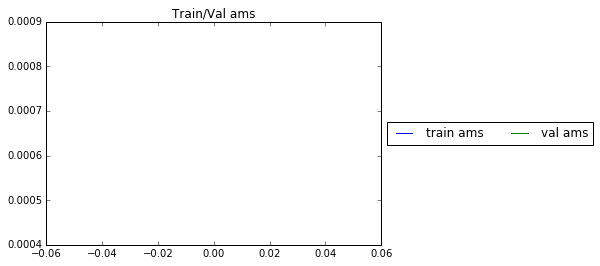

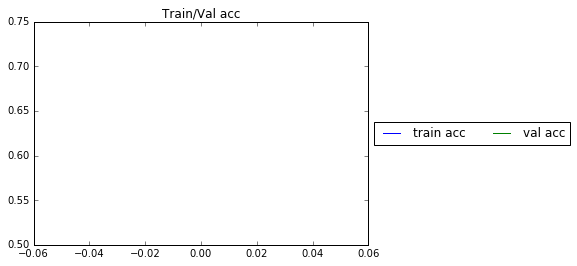

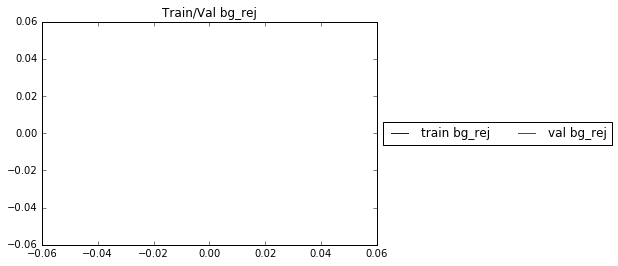

Epoch 1 of 20000 took 87.461s
		tr_sig_eff:		100.0000 %
		tr_loss:		13.9849 %
		tr_phys_cuts_sig_eff:		23.9395 %
		tr_sig_eff_at_0.9996:		100.0000 %
		tr_bg_rej:		0.0000 %
		tr_acc:		71.2576 %
		tr_ams:		0.0009
		tr_phys_cuts_ams:		0.0387
		tr_phys_cuts_bg_rej:		99.9916 %
	Validation took 8.830s
		val_sig_eff_at_0.9996:		100.0000 %
		val_phys_cuts_sig_eff:		24.5042 %
		val_sig_eff:		100.0000 %
		val_loss:		715.4152 %
		val_phys_cuts_ams:		0.0105
		val_phys_cuts_bg_rej:		100.0000 %
		val_ams:		0.0004
		val_acc:		50.1019 %
		val_bg_rej:		0.0000 %


beginning epoch 1
beginning epoch 1


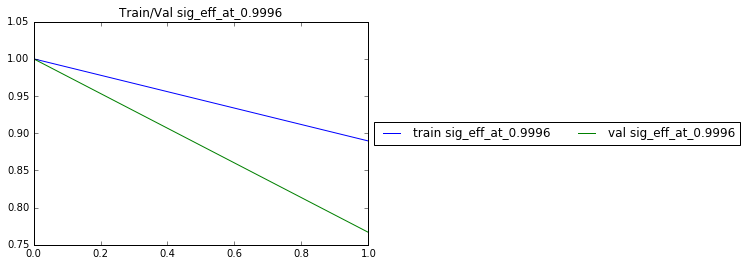

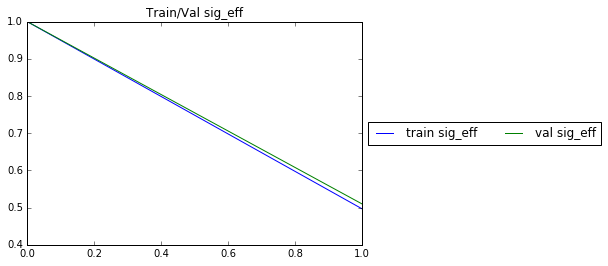

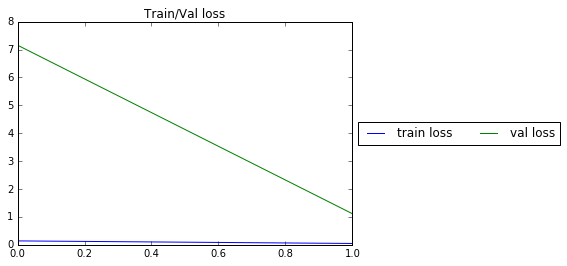

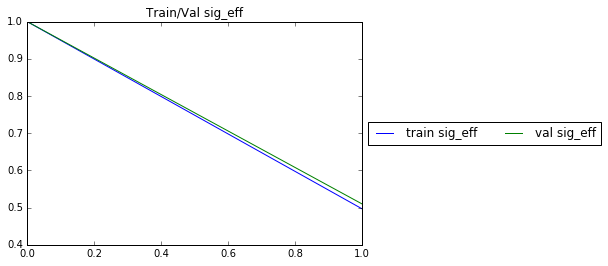

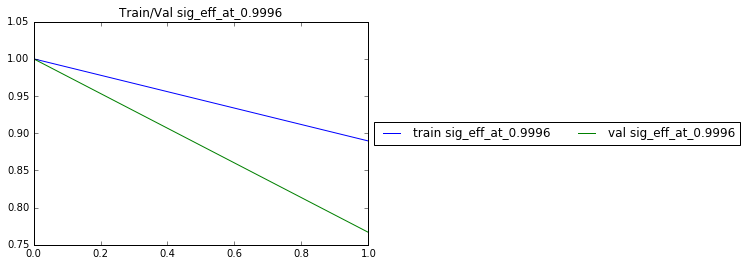

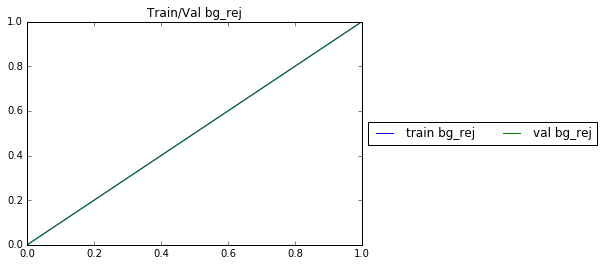

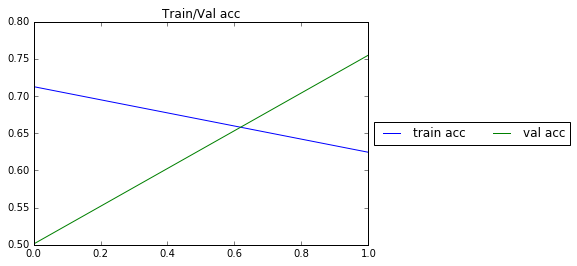

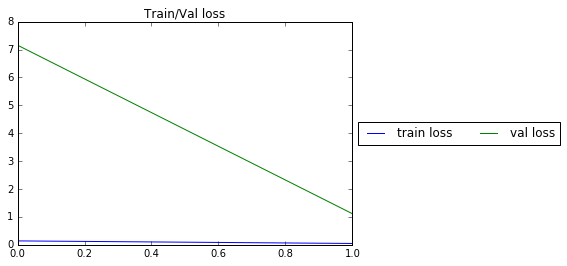

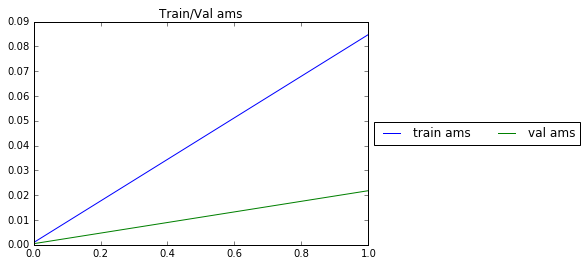

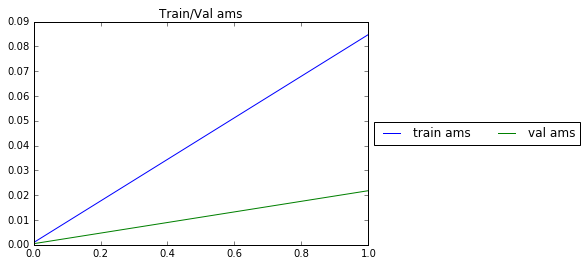

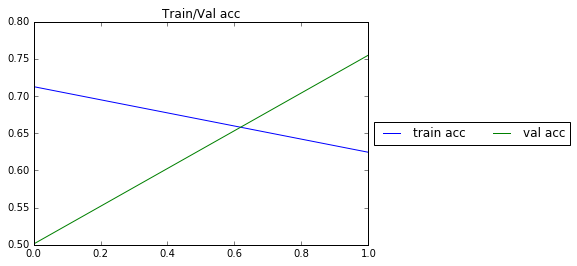

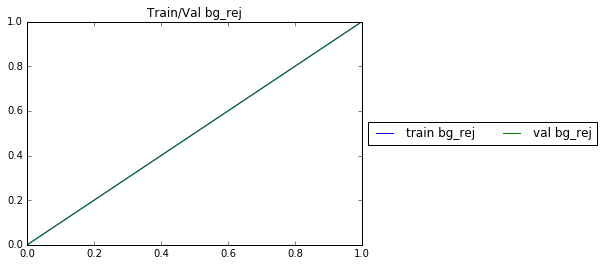

Epoch 2 of 20000 took 87.151s
		tr_sig_eff:		49.6766 %
		tr_loss:		4.7746 %
		tr_phys_cuts_sig_eff:		23.9395 %
		tr_sig_eff_at_0.9996:		88.9542 %
		tr_bg_rej:		100.0000 %
		tr_acc:		62.4370 %
		tr_ams:		0.0848
		tr_phys_cuts_ams:		0.0387
		tr_phys_cuts_bg_rej:		99.9916 %
	Validation took 8.400s
		val_sig_eff_at_0.9996:		76.6723 %
		val_phys_cuts_sig_eff:		24.5042 %
		val_sig_eff:		50.9916 %
		val_loss:		111.4308 %
		val_phys_cuts_ams:		0.0105
		val_phys_cuts_bg_rej:		100.0000 %
		val_ams:		0.0218
		val_acc:		75.4925 %
		val_bg_rej:		100.0000 %


beginning epoch 2
beginning epoch 2


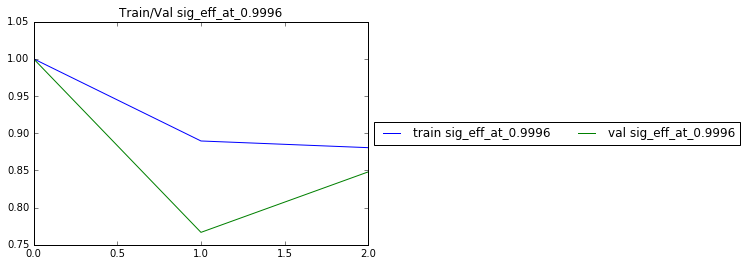

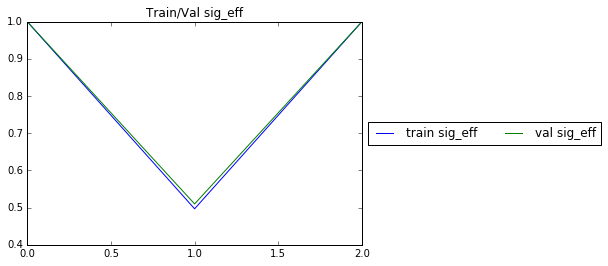

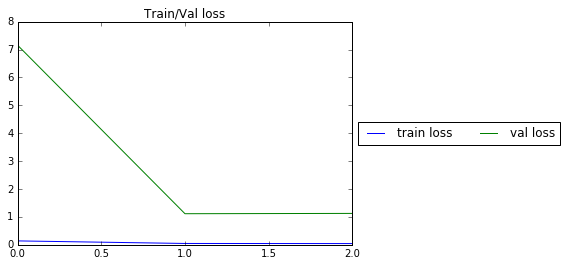

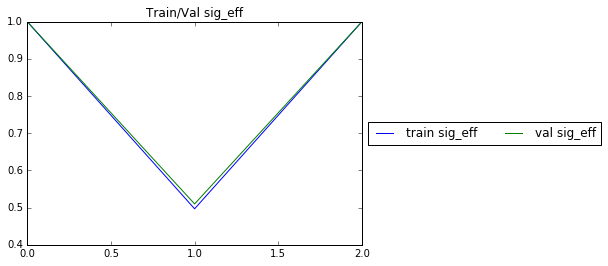

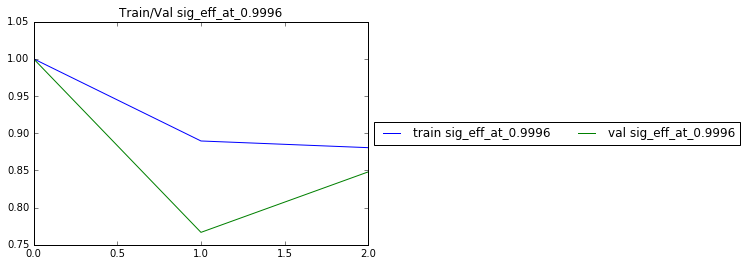

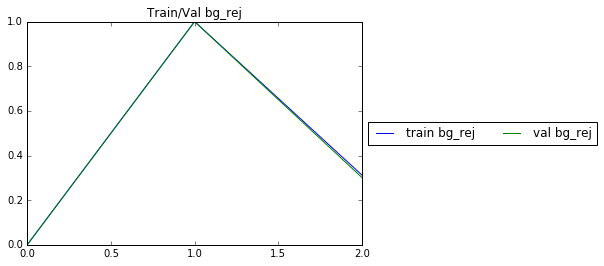

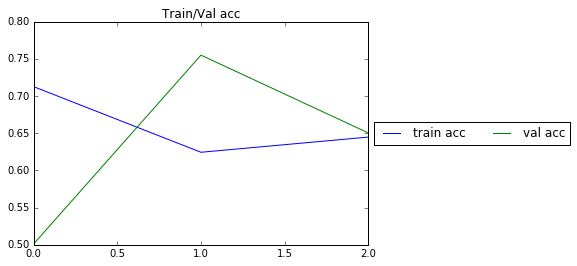

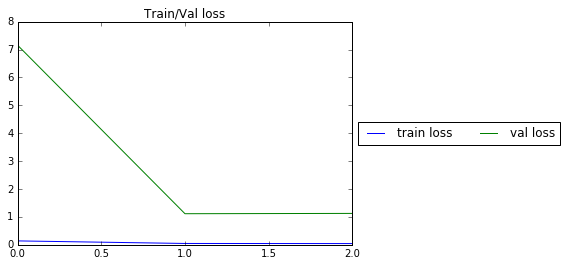

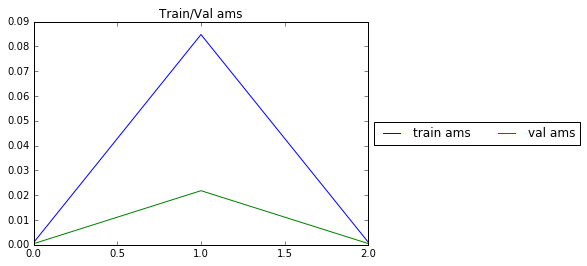

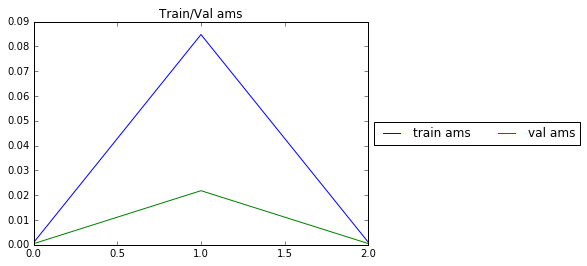

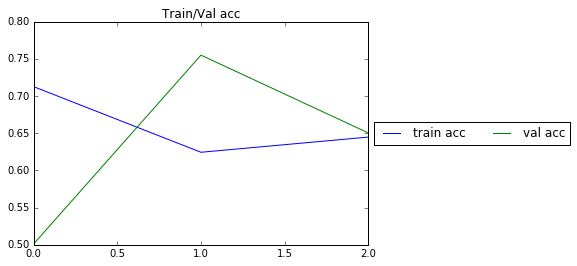

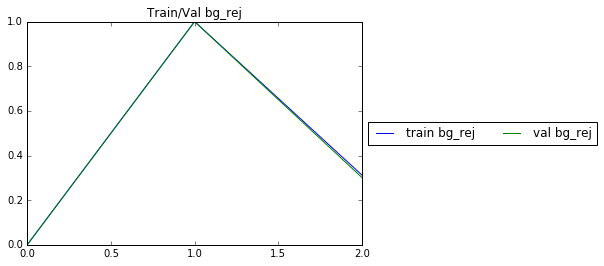

Epoch 3 of 20000 took 85.835s
		tr_sig_eff:		100.0000 %
		tr_loss:		4.4263 %
		tr_phys_cuts_sig_eff:		23.9395 %
		tr_sig_eff_at_0.9996:		88.0554 %
		tr_bg_rej:		31.2190 %
		tr_acc:		64.4783 %
		tr_ams:		0.0010
		tr_phys_cuts_ams:		0.0387
		tr_phys_cuts_bg_rej:		99.9916 %
	Validation took 8.418s
		val_sig_eff_at_0.9996:		84.8067 %
		val_phys_cuts_sig_eff:		24.5042 %
		val_sig_eff:		100.0000 %
		val_loss:		112.5105 %
		val_phys_cuts_ams:		0.0105
		val_phys_cuts_bg_rej:		100.0000 %
		val_ams:		0.0005
		val_acc:		65.0306 %
		val_bg_rej:		30.0974 %


beginning epoch 3
beginning epoch 3


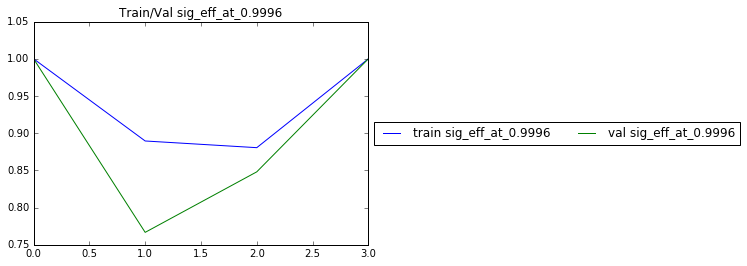

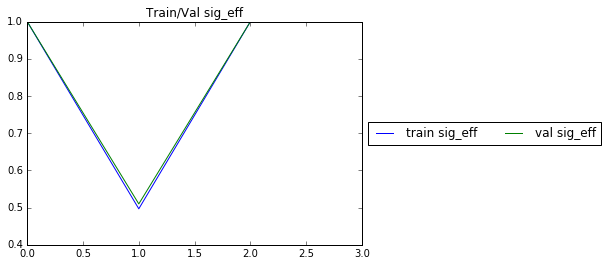

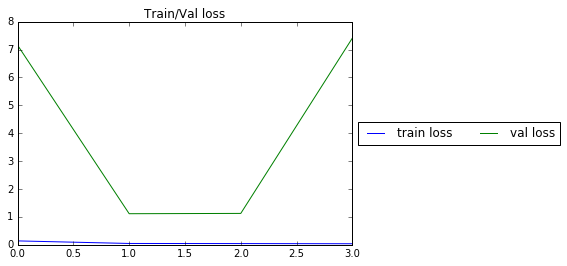

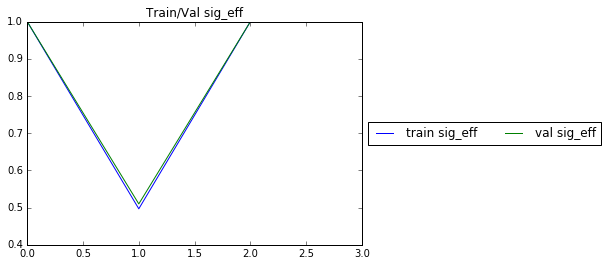

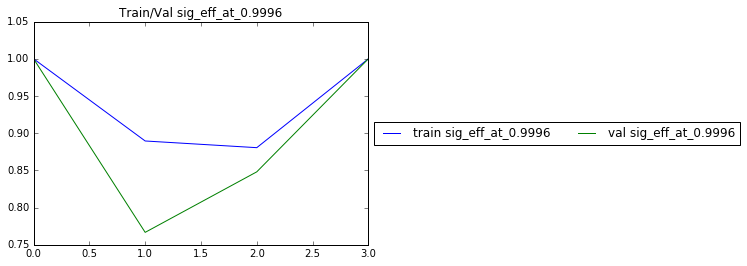

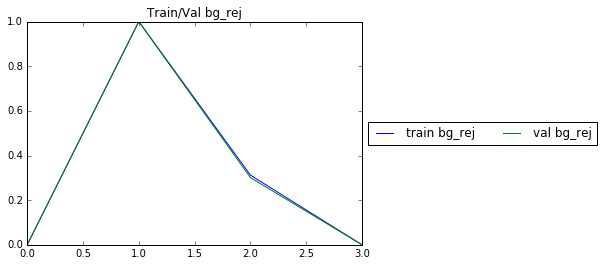

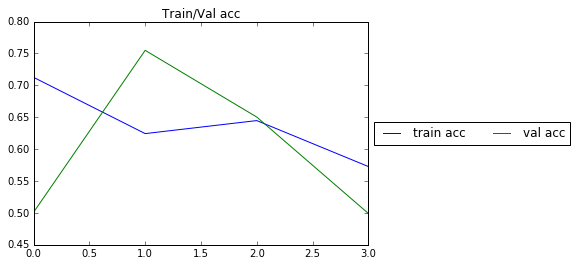

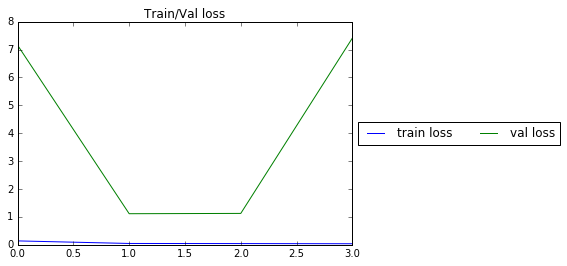

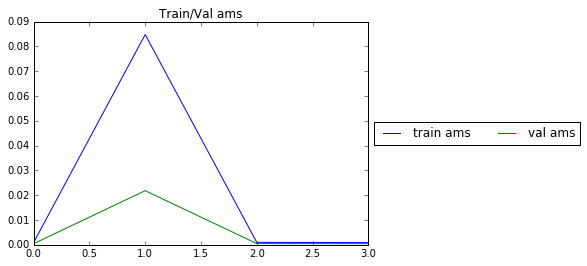

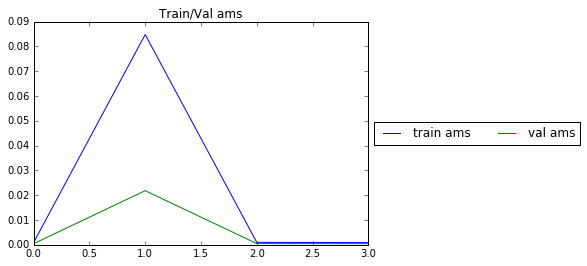

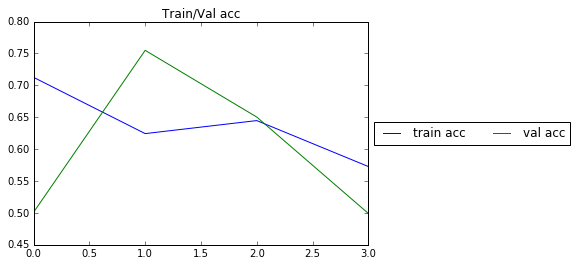

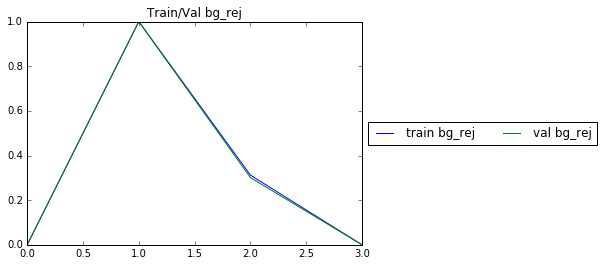

Epoch 4 of 20000 took 86.419s
		tr_sig_eff:		100.0000 %
		tr_loss:		3.8133 %
		tr_phys_cuts_sig_eff:		23.9395 %
		tr_sig_eff_at_0.9996:		100.0000 %
		tr_bg_rej:		0.0000 %
		tr_acc:		57.2707 %
		tr_ams:		0.0009
		tr_phys_cuts_ams:		0.0387
		tr_phys_cuts_bg_rej:		99.9916 %
	Validation took 8.326s
		val_sig_eff_at_0.9996:		100.0000 %
		val_phys_cuts_sig_eff:		24.5042 %
		val_sig_eff:		100.0000 %
		val_loss:		740.9789 %
		val_phys_cuts_ams:		0.0105
		val_phys_cuts_bg_rej:		100.0000 %
		val_ams:		0.0004
		val_acc:		49.9151 %
		val_bg_rej:		0.0000 %


beginning epoch 4
beginning epoch 4


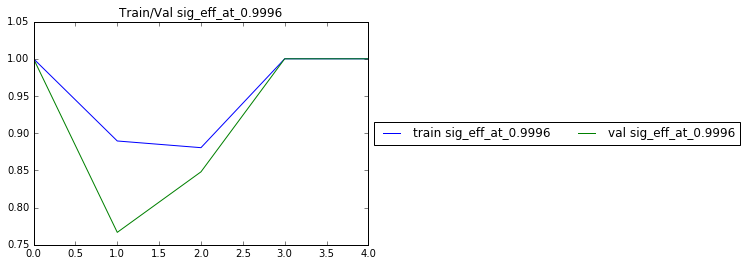

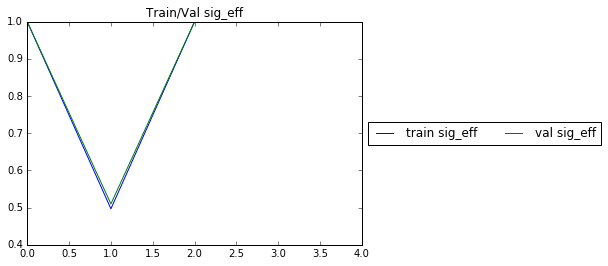

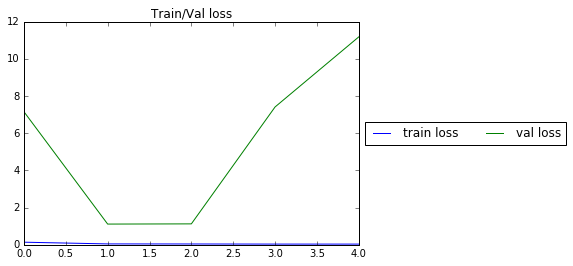

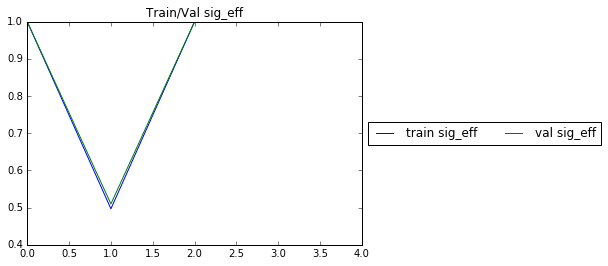

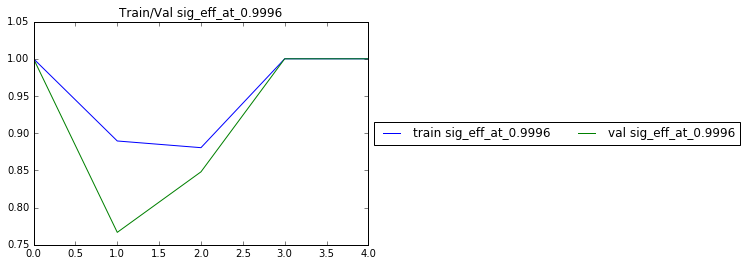

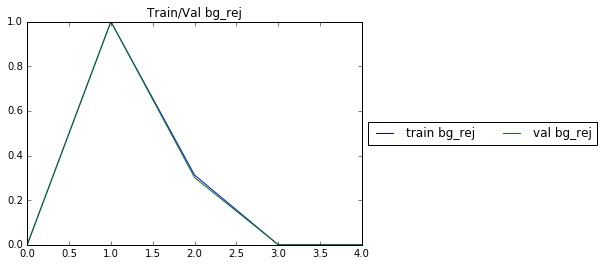

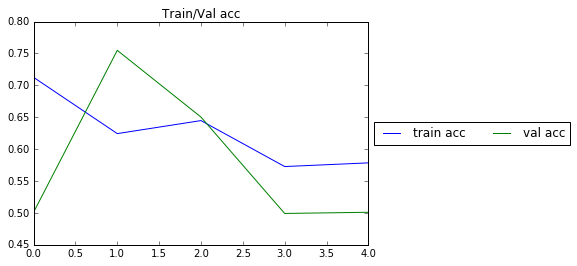

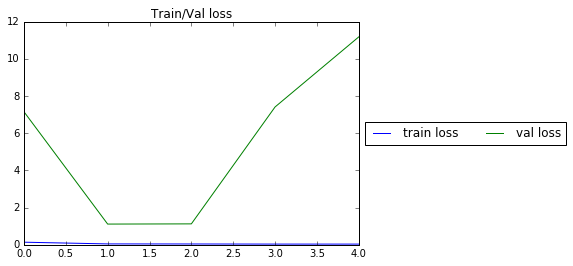

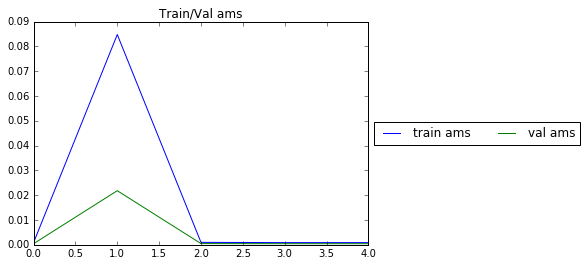

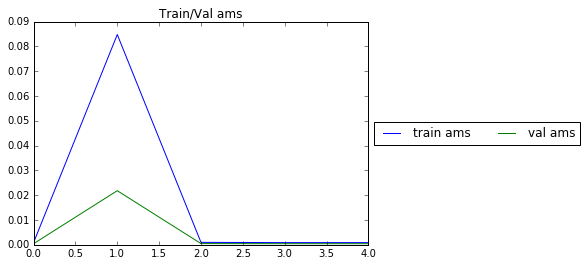

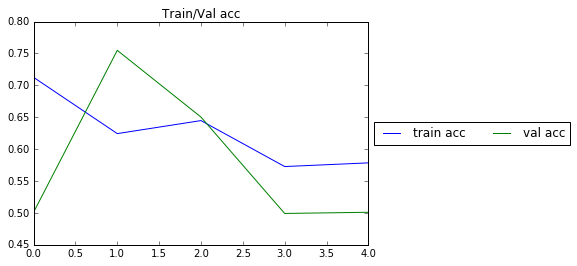

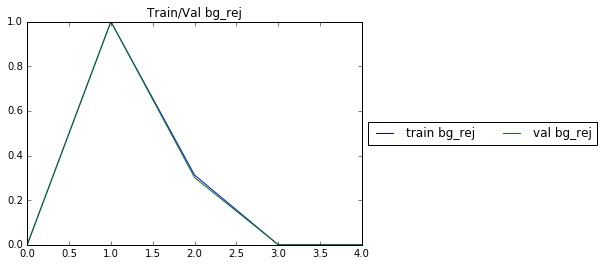

Epoch 5 of 20000 took 87.327s
		tr_sig_eff:		100.0000 %
		tr_loss:		3.7648 %
		tr_phys_cuts_sig_eff:		23.9395 %
		tr_sig_eff_at_0.9996:		100.0000 %
		tr_bg_rej:		0.0000 %
		tr_acc:		57.8461 %
		tr_ams:		0.0009
		tr_phys_cuts_ams:		0.0387
		tr_phys_cuts_bg_rej:		99.9916 %
	Validation took 8.805s
		val_sig_eff_at_0.9996:		100.0000 %
		val_phys_cuts_sig_eff:		24.5042 %
		val_sig_eff:		100.0000 %
		val_loss:		1117.7030 %
		val_phys_cuts_ams:		0.0105
		val_phys_cuts_bg_rej:		100.0000 %
		val_ams:		0.0004
		val_acc:		50.1019 %
		val_bg_rej:		0.0000 %


beginning epoch 5
beginning epoch 5


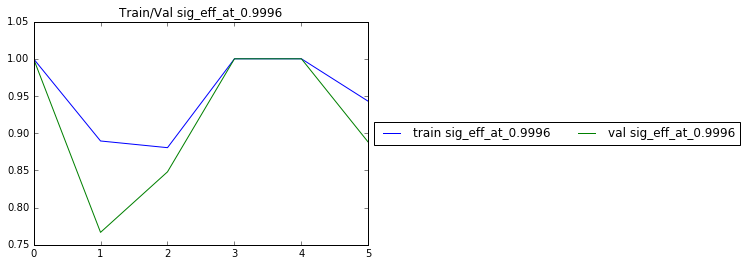

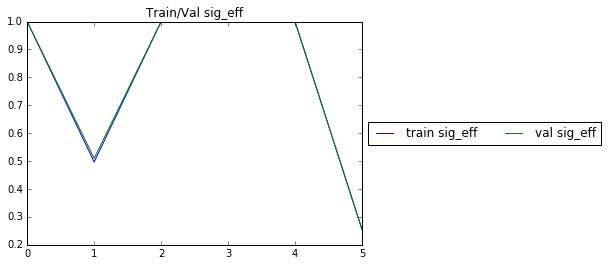

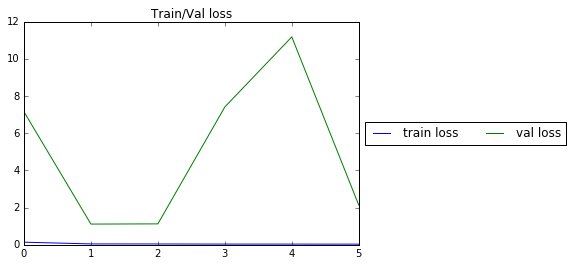

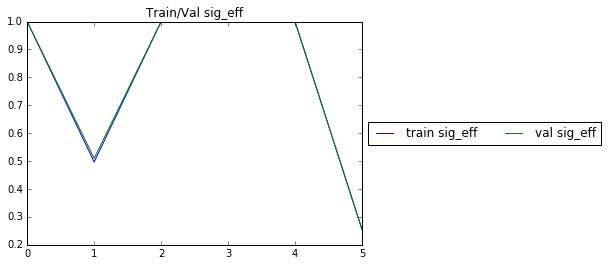

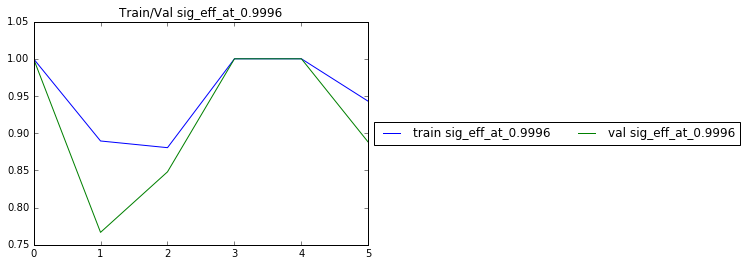

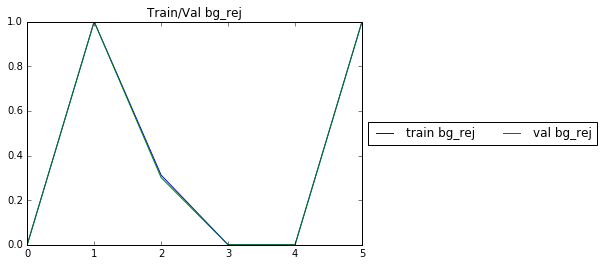

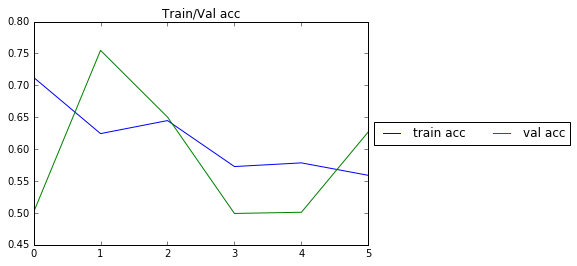

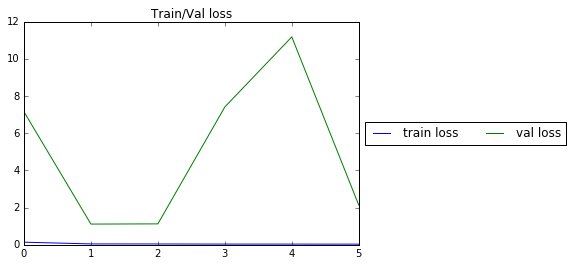

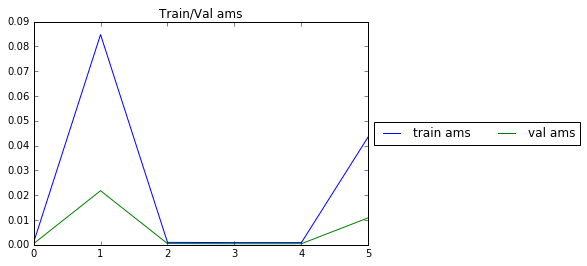

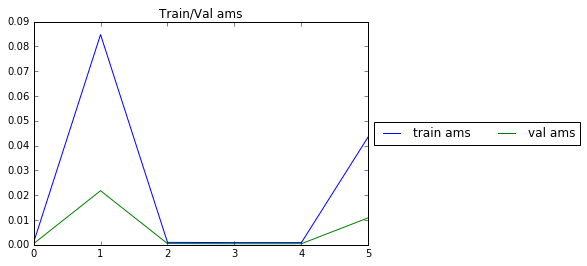

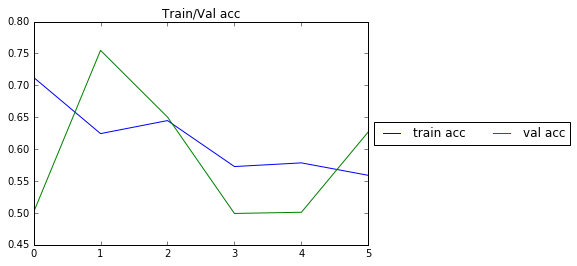

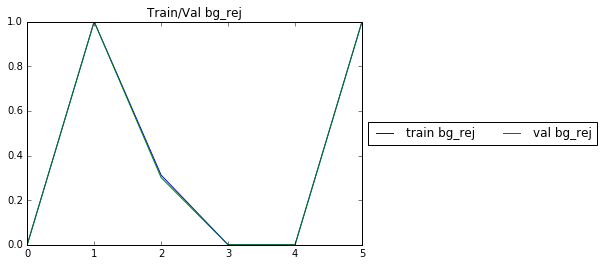

Epoch 6 of 20000 took 88.107s
		tr_sig_eff:		25.5103 %
		tr_loss:		3.4912 %
		tr_phys_cuts_sig_eff:		23.9395 %
		tr_sig_eff_at_0.9996:		94.2797 %
		tr_bg_rej:		100.0000 %
		tr_acc:		55.8930 %
		tr_ams:		0.0436
		tr_phys_cuts_ams:		0.0387
		tr_phys_cuts_bg_rej:		99.9916 %
	Validation took 8.756s
		val_sig_eff_at_0.9996:		88.7731 %
		val_phys_cuts_sig_eff:		24.5042 %
		val_sig_eff:		25.4454 %
		val_loss:		213.5635 %
		val_phys_cuts_ams:		0.0105
		val_phys_cuts_bg_rej:		100.0000 %
		val_ams:		0.0109
		val_acc:		62.7208 %
		val_bg_rej:		100.0000 %


beginning epoch 6


KeyboardInterrupt: 

In [3]:
if __name__ == "__main__":
    
    kwargs = setup_kwargs()
    
    h5_prefix = "/global/cscratch1/sd/racah/atlas_h5/"
    
    dl = DataLoader(bg_cfg_file=[join(h5_prefix, "jetjet_JZ4.h5"),
                                 join(h5_prefix, "jetjet_JZ5.h5")],
                    sig_cfg_file=join(h5_prefix, "GG_RPV10_1400_850.h5"),
                    num_events=kwargs["num_events"], 
                    type_="hdf5",
                    use_premade=True, test=kwargs["test"])
    tr,val = dl.load_data()
    kwargs["num_train"], kwargs["num_val"] = tr["x"].shape[0], val["x"].shape[0]
    kwargs["logger"].info(str(kwargs))
    dump_hyperparams(dic=kwargs,path=kwargs["save_path"])
    networks, fns = build_network(kwargs, build_layers(kwargs))
    
    
    tv = TrainVal(tr,val, kwargs, fns, networks)
    tv.train()

    
    
    

In [ ]:
# h5_prefix = "/project/projectdirs/dasrepo/atlas_rpv_susy/hdf5/prod003_2016_11_14"

# a=h5py.File(join(h5_prefix,"GG_RPV10_1400_850.h5" ))

# w=a["event_10"]["weight"]

# w.value

# g.value

# # x.shape

# # #test
# # x, y, xv,yv = load_train_val(num_events=100000)

# # def test_network(network_path):
# #     x_te, y_te = load_test()

# #     net = pickle.load(open(network_path))

# #     cfg = build_network(network_kwargs,net)
# #     return cfg['val_fn'](x_te, y_te)

# # network_path = './results/run84/model.pkl'



# # net = pickle.load(open(network_path))

# # cfg = build_network(network_kwargs,net)

# # y_pred = cfg['out_fn'](xv)

# # y_pred = y_pred[0]

# # best_sig = xv[np.argmax(y_pred[:,1])]

# # best_bg = xv[np.argmin(y_pred[:,1])]

# # plot_example(np.squeeze(best_sig))

# # plot_example(np.squeeze(best_bg))

# # inds = np.argsort(y_pred[:,1], axis=0)

# # best_bgs = np.squeeze(xv[inds[:25]])

# # best_sigs = np.squeeze(xv[inds[-26:-1]])

# # plot_examples(best_bgs,5, run_dir,"best_bg")

# # plot_examples(best_sigs,5, run_dir, "best_sig")

# # plot_filters(net,save_dir=run_dir)

# # plot_feature_maps(best_bgs[0], net, run_dir, name="best_bg")

# # best_bg = np.expand_dims(np.expand_dims(best_bgs[0], axis=0),axis=0)
# # best_sig = np.expand_dims(np.expand_dims(best_sigs[-1], axis=0),axis=0)
# # saliency_fn = compile_saliency_function(net)
# # saliency, max_class = saliency_fn(best_sig)
# # #np.squeeze(np.abs(saliency)).shape
# # show_images(best_sigs[-1], saliency, max_class, "default gradient", save_dir=run_dir)



